In [25]:
from ema_workbench import Scenario, Policy, MultiprocessingEvaluator, ema_logging, load_results
from ema_workbench.analysis import prim
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ema_workbench.analysis import parcoords
import seaborn as sns
import funs_project as fp

# Optimisation

In [26]:
ACTORNAME = "Deventer"

In [27]:
dike_model, planning_steps = get_model_for_problem_formulation(ACTORNAME)
outcomekeys = [outcome.name for outcome in dike_model.outcomes]

## Reading

In [28]:
cases = fp.the_cases(ACTORNAME)

In [29]:
policies = fp.crude_policy_selection(ACTORNAME, 6)

In [43]:
policies = policies.sort_values(by="scenario")

Below we plot per scenario 

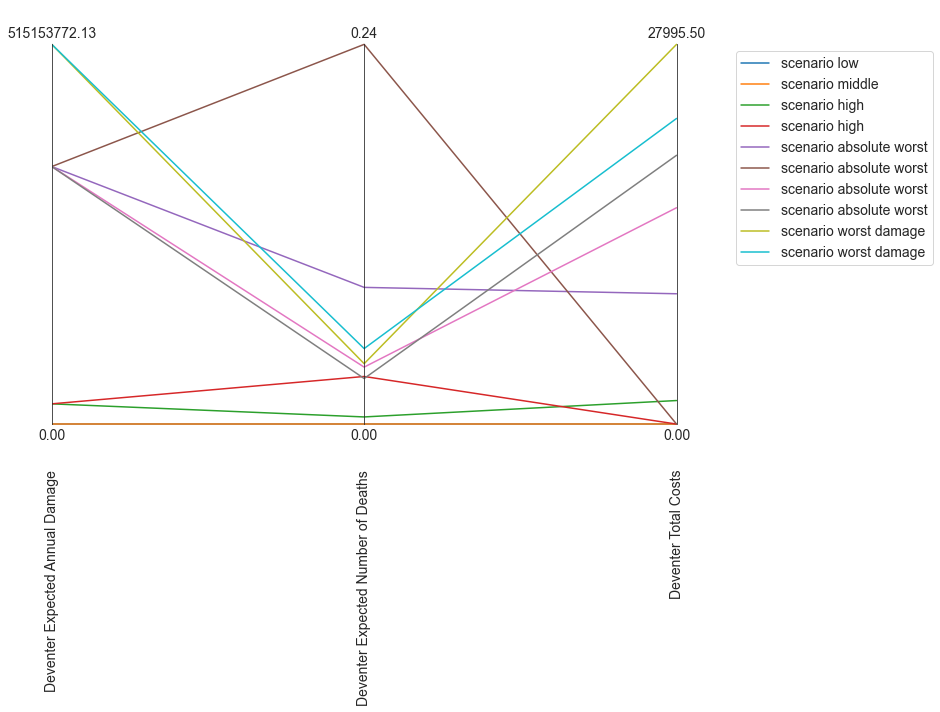

In [44]:
colors = iter(sns.color_palette())
limits = parcoords.get_limits(policies.iloc[:, 10:13])

# limits.loc[0, ['inertia', 'reliability']] = 1
# limits.loc[0, 'max_P'] = 4 # max over results based on quick inspection not shown here
# limits.loc[0, 'utility'] = 1 # max over results based on quick inspection not shown here
# limits.loc[1, :] = 0
paraxes = parcoords.ParallelAxes(limits)


for index, row in policies.iterrows():
    color = next(colors)
    paraxes.plot(row, label=f'scenario {cases[row.scenario]}', color=color)

paraxes.legend()
plt.rcParams["figure.figsize"] = (10,10)

plt.show()


# Reevaluate under deep uncertainty

## Reading

In [46]:
n_scenarios = 1000

In [47]:
du_experiments, du_outcomes = load_results("simulation/optimisation/du_scen_" + str(n_scenarios) + "_" + ACTORNAME + ".tar.gz")

## Regret
Comparing alternatives
"With a regret view, a decision maker wants to minimize the regret of choosing incorrectly, where regret is the loss in performance. This regret could be the cost of assuming the wrong future scenario or the cost of choosing the wrong alternative. In the first case, maximum regret of an alternative is the difference between its performances in the best estimate future scenario and in the scenario where it shows the worst performance, for example, as applied by Kasprzyk et al. (2013). In the second case, the regret of an alternative in a certain future scenario is the difference between its performance and the best-performing alternative, as proposed by Savage (1951). Maximum regret of an alternative is its highest regret achieved over all future scenarios. In both regret cases, the alternative with the smallest maximum regret is the most robust."

https://link.springer.com/article/10.1007/s13595-017-0641-2

In [48]:
outcomekeys = list(du_outcomes.keys())
outcomekeys

['Deventer Expected Annual Damage',
 'Deventer Expected Number of Deaths',
 'Deventer Total Costs']

In [49]:
DAMAGE = outcomekeys[0]
DEATHS = outcomekeys[1]
COSTS = outcomekeys[2]

Regret calculation based on assignments

In [50]:
overall_scores = {}
regret = []
for scenario in du_experiments.scenario.unique():
    logical = du_experiments.scenario==scenario
    temp_results = {k:v[logical] for k,v in du_outcomes.items()}
    temp_results = pd.DataFrame(temp_results)
    temp_experiments = du_experiments[du_experiments.scenario==scenario]
    best = temp_results.min()
    scenario_regret = temp_results - best
    scenario_regret['policy'] = temp_experiments.policy.values
    regret.append(scenario_regret)

In [51]:
regret = pd.concat(regret)
maxregret = regret.groupby('policy').max()

In [52]:
maxregret

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs
policy,,,
scenario absolute worst option 0,1.975364e+08,0.158755,29976.698139
scenario absolute worst option 1,1.960830e+08,0.022271,61826.939912
scenario absolute worst option 2,1.975364e+08,0.028105,49766.002770
scenario absolute worst option 3,1.975364e+08,0.581652,0.000000
scenario best option 0,4.521167e+08,0.214667,32119.930396
scenario high option 0,1.969750e+08,0.581652,0.000000
scenario high option 1,1.974474e+08,0.028085,49766.002770
scenario low option 0,1.486332e+08,0.581184,0.000000
scenario middle option 0,1.975364e+08,0.022484,72131.429897


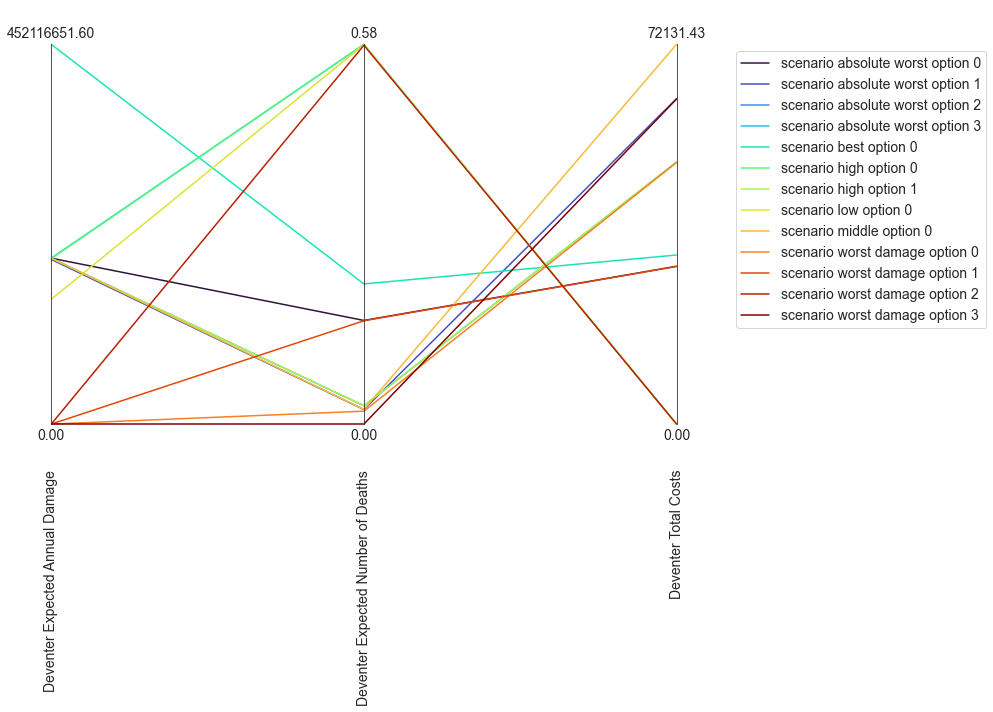

(None,)

In [53]:
from matplotlib import cm

limits = parcoords.get_limits(maxregret)
paraxes = parcoords.ParallelAxes(maxregret)


cmap = cm.get_cmap('turbo', maxregret.shape[0])
i=0
for index, row in maxregret.iterrows():
    paraxes.plot(row, color=cmap.colors[i], label=index)
    i+=1
    
paraxes.legend()
plt.savefig("../../report/figures/regret_figure"+ "_" + ACTORNAME+ ".png", bbox_inches="tight")
plt.show(),

## Satisficing
Performance threshold
"seeks a decision alternative that meets his or her performance requirements over the range of plausible future scenarios. "

For the city of Deventer, treshold values for Damage, Deaths and Costs are listed below. These values are based on ...
- Damage: 3.5e8
- Deaths: 0.05
- Costs: 16000

## These are a guestimate based on the table above, a better number is still more important

In [56]:
n_deventer = 100719 #can be removed once stuff is imported as Lisette wanted
thresholds = {'Deventer Expected Annual Damage': 1.1e6, 'Deventer Expected Number of Deaths': (1e-5*n_deventer),
              'Deventer Total Costs': 1.1e7}
satisfycing_df = policies.copy()
satisfycing_df.drop_duplicates(inplace=True)
#satisfycing_df

In [57]:
belowtresh_df = satisfycing_df.loc[(satisfycing_df['Deventer Expected Annual Damage'] < thresholds['Deventer Expected Annual Damage']) & \
                    (satisfycing_df['Deventer Expected Number of Deaths'] < thresholds['Deventer Expected Number of Deaths']) & \
                    (satisfycing_df['Deventer Total Costs'] < thresholds['Deventer Total Costs']),:].copy()
belowtresh_df.sort_index(inplace=True, ascending = False)
belowtresh_df

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,scenario
2,1,1,1,0,0,0,4,10,10,5,0.0,0.0,0.0,2
1,1,1,1,0,0,0,0,0,9,0,0.0,0.0,0.0,1


In [77]:
limits_df = belowtresh_df.iloc[:, -4:-1]
colors = iter(sns.color_palette())
limits = parcoords.get_limits(limits_df)

In [78]:

overall_scores = {}
for policy in du_experiments.policy.unique():
    logical = du_experiments.policy == policy
    scores = {}
    for k, v in du_outcomes.items():
        try:
            n = np.sum(v[logical]<=thresholds[k])
        except KeyError:
            continue
        scores[k] = n/1000 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

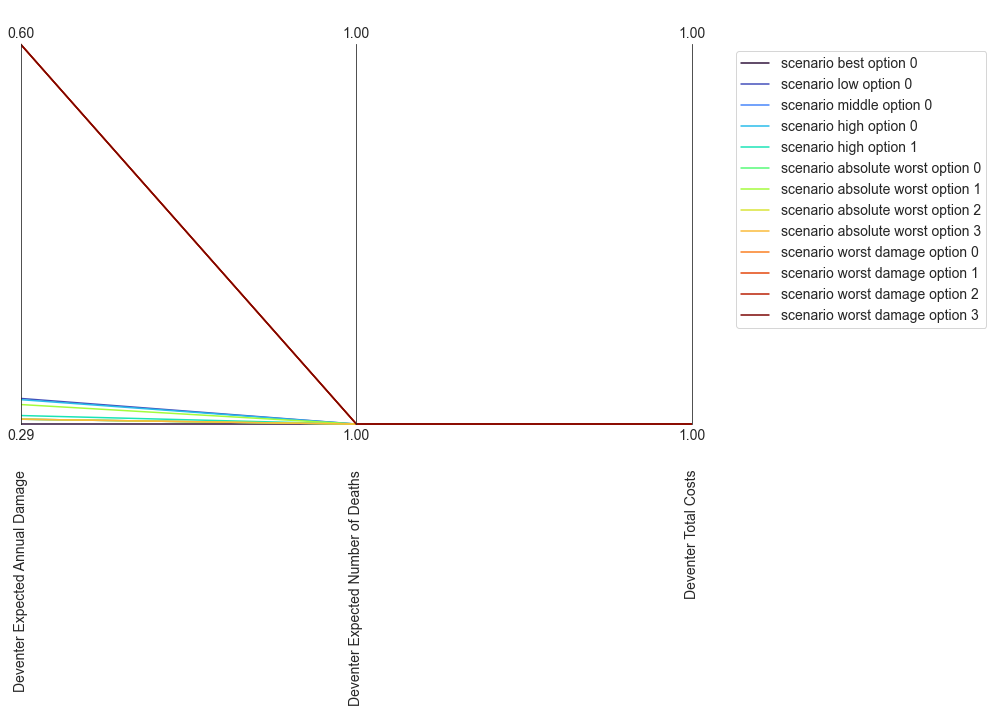

In [79]:
from matplotlib import cm

limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)


cmap = cm.get_cmap('turbo', overall_scores.shape[0])
i=0
for index, row in overall_scores.iterrows():
    paraxes.plot(row, color=cmap.colors[i], label=index)
    i+=1
    
paraxes.legend()
plt.savefig("../../report/figures/domain_criterion"+ "_" + ACTORNAME+ ".png", bbox_inches="tight")
plt.show()

In [80]:
overall_scores

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs
scenario best option 0,0.292,1.0,1.0
scenario low option 0,0.313,1.0,1.0
scenario middle option 0,0.296,1.0,1.0
scenario high option 0,0.312,1.0,1.0
scenario high option 1,0.299,1.0,1.0
scenario absolute worst option 0,0.296,1.0,1.0
scenario absolute worst option 1,0.308,1.0,1.0
scenario absolute worst option 2,0.296,1.0,1.0
scenario absolute worst option 3,0.296,1.0,1.0
scenario worst damage option 0,0.603,1.0,1.0


## Scoring policies

### Normalise the regret and take the average to score the policies


In [62]:
from sklearn import preprocessing

In [63]:
#Normalize the regret results
regret_scores = maxregret.copy()
regret_average = regret_scores.apply(lambda x: x/x.max(), axis=0)


In [64]:
#Get the average for each policy
regret_average['average regret'] = regret_average.mean(numeric_only=True, axis=1)
regret_average.sort_values(by='average regret', ascending = False, inplace = True) #Lower = better
regret_average

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,average regret
policy,,,,
scenario best option 0,1.000000,0.369065,0.445297,0.604787
scenario middle option 0,0.436915,0.038655,1.000000,0.491857
scenario absolute worst option 3,0.436915,1.000000,0.000000,0.478972
scenario high option 0,0.435673,1.000000,0.000000,0.478558
scenario absolute worst option 1,0.433700,0.038290,0.857143,0.443044
scenario low option 0,0.328750,0.999197,0.000000,0.442649
scenario absolute worst option 2,0.436915,0.048319,0.689935,0.391723
scenario high option 1,0.436718,0.048286,0.689935,0.391646
scenario absolute worst option 0,0.436915,0.272938,0.415584,0.375146


###  Use the satisficing / domain criterion and take their average to score the policies


In [65]:
#Get the average for each policy
satisficing_average = overall_scores.copy()
satisficing_average['average satisficing'] = satisficing_average.mean(numeric_only=True, axis=1)
satisficing_average.sort_values(by='average satisficing', ascending = True, inplace = True) #higher = better
satisficing_average

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,average satisficing
scenario best option 0,0.292,1.0,1.0,0.764000
scenario middle option 0,0.296,1.0,1.0,0.765333
scenario absolute worst option 0,0.296,1.0,1.0,0.765333
scenario absolute worst option 2,0.296,1.0,1.0,0.765333
scenario absolute worst option 3,0.296,1.0,1.0,0.765333
scenario high option 1,0.299,1.0,1.0,0.766333
scenario absolute worst option 1,0.308,1.0,1.0,0.769333
scenario high option 0,0.312,1.0,1.0,0.770667
scenario low option 0,0.313,1.0,1.0,0.771000
scenario worst damage option 0,0.603,1.0,1.0,0.867667


### Add them together  

In [66]:
merged_df = pd.concat([satisficing_average, regret_average], join="inner", axis = 1)


In [67]:
merged_df.sort_values(by='average satisficing', inplace = True, ascending = True)
merged_df.sort_values(by='average regret', inplace = True, ascending = False)
merged_df

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,average satisficing,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,average regret
scenario best option 0,0.292,1.0,1.0,0.764000,1.000000,0.369065,0.445297,0.604787
scenario middle option 0,0.296,1.0,1.0,0.765333,0.436915,0.038655,1.000000,0.491857
scenario absolute worst option 3,0.296,1.0,1.0,0.765333,0.436915,1.000000,0.000000,0.478972
scenario high option 0,0.312,1.0,1.0,0.770667,0.435673,1.000000,0.000000,0.478558
scenario absolute worst option 1,0.308,1.0,1.0,0.769333,0.433700,0.038290,0.857143,0.443044
scenario low option 0,0.313,1.0,1.0,0.771000,0.328750,0.999197,0.000000,0.442649
scenario absolute worst option 2,0.296,1.0,1.0,0.765333,0.436915,0.048319,0.689935,0.391723
scenario high option 1,0.299,1.0,1.0,0.766333,0.436718,0.048286,0.689935,0.391646
scenario absolute worst option 0,0.296,1.0,1.0,0.765333,0.436915,0.272938,0.415584,0.375146
scenario worst damage option 2,0.603,1.0,1.0,0.867667,0.000000,0.997590,0.000000,0.332530


In [68]:
#take te most robust policies and put them into a df.
robust_policies = merged_df.tail(5)
robust_policies

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,average satisficing,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,average regret
scenario absolute worst option 0,0.296,1.0,1.0,0.765333,0.436915,0.272938,0.415584,0.375146
scenario worst damage option 2,0.603,1.0,1.0,0.867667,0.000000,0.997590,0.000000,0.332530
scenario worst damage option 3,0.603,1.0,1.0,0.867667,0.000000,0.000000,0.855976,0.285325
scenario worst damage option 0,0.603,1.0,1.0,0.867667,0.000000,0.034009,0.688995,0.241001
scenario worst damage option 1,0.603,1.0,1.0,0.867667,0.000000,0.272070,0.415018,0.229029


In [69]:
#now to return to an original list of policies with this
du_experiments.policy.unique()

['scenario best option 0', 'scenario low option 0', 'scenario middle option 0', 'scenario high option 0', 'scenario high option 1', ..., 'scenario absolute worst option 3', 'scenario worst damage option 0', 'scenario worst damage option 1', 'scenario worst damage option 2', 'scenario worst damage option 3']
Length: 13
Categories (13, object): ['scenario best option 0', 'scenario low option 0', 'scenario middle option 0', 'scenario high option 0', ..., 'scenario worst damage option 0', 'scenario worst damage option 1', 'scenario worst damage option 2', 'scenario worst damage option 3']

In [ ]:
scenario 